In [ ]:
pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models,layers
from keras import Model
from keras.layers.merge import concatenate
from keras.layers import Bidirectional, LSTM, Input, Dense
from keras.layers import Dropout
import math 
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import yfinance as yf
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.models import load_model

In [ ]:
df = yf.download("FB",start="2015-01-02", end="2021-01-02")
df=df.drop(['Adj Close','High','Low','Close','Volume'],axis=1)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_senti=pd.read_csv('sentiment_data_vader.csv',index_col='Date', usecols=['Date'])
len(df_senti)

2192

In [ ]:
df_senti.index=pd.to_datetime(df_senti.index)
result = pd.concat([df, df_senti], axis=1, join="outer")

In [ ]:
result['Open']=result['Open'].interpolate(method='quadratic')

In [ ]:
df=result
df=df.dropna()

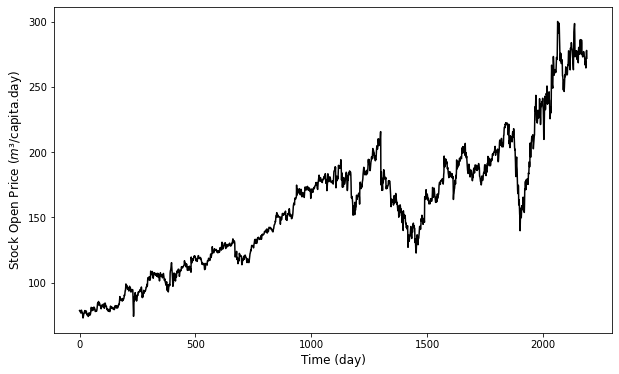

In [ ]:
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Stock Open Price ($m³$/capita.day)', {'fontsize': 12})
dataset = df.copy()
timeseries(list(range(len(df))), dataset['Open'], 'Time (day)')

In [ ]:
train_size= int(len(df)*0.9)
train_main= df.iloc[:train_size]
test_main=df.iloc[train_size:]

In [ ]:
cnt=MinMaxScaler()
cnt_transformer=cnt.fit(train_main[['Open']])
train_scaled=cnt_transformer.transform(train_main[['Open']])
test_scaled=cnt_transformer.transform(test_main[['Open']])

In [ ]:
def dataset(Y, time_steps):
  x=[]
  y=[]
  for i in range(len(Y)-time_steps):
    v=Y[i:(i+time_steps)]
    u=Y[i+time_steps]
    x.append(v)
    y.append(u)
  return np.array(x),np.array(y)

In [ ]:
TRAIN_X_val,TRAIN_Y=dataset(train_scaled,time_steps=5)
TEST_X_val,TEST_Y=dataset(test_scaled,time_steps=5)

In [ ]:
model=models.Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(5, 1)))
#model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 5, 256)            133120    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 527,617
Trainable params: 527,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model_checkpoint = ModelCheckpoint('timeseriesmodel.hdf5',
                                   monitor='val_mae',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')
model.compile(loss='mae',optimizer=optimizer, metrics=['mse','mae'])

In [ ]:
history=model.fit(TRAIN_X_val,TRAIN_Y,epochs=40, batch_size=10,validation_split=0.1,shuffle=True, callbacks=[model_checkpoint])

Epoch 1/40
177/177 [==============================] - 10s 22ms/step - loss: 0.0976 - mse: 0.0299 - mae: 0.0976 - val_loss: 0.0209 - val_mse: 8.4788e-04 - val_mae: 0.0209

Epoch 00001: val_mae improved from inf to 0.02093, saving model to timeseriesmodel.hdf5
Epoch 2/40
177/177 [==============================] - 2s 14ms/step - loss: 0.0184 - mse: 5.8621e-04 - mae: 0.0184 - val_loss: 0.0211 - val_mse: 8.0562e-04 - val_mae: 0.0211

Epoch 00002: val_mae did not improve from 0.02093
Epoch 3/40
177/177 [==============================] - 2s 14ms/step - loss: 0.0207 - mse: 7.7871e-04 - mae: 0.0207 - val_loss: 0.0644 - val_mse: 0.0051 - val_mae: 0.0644

Epoch 00003: val_mae did not improve from 0.02093
Epoch 4/40
177/177 [==============================] - 2s 14ms/step - loss: 0.0185 - mse: 5.8863e-04 - mae: 0.0185 - val_loss: 0.0329 - val_mse: 0.0015 - val_mae: 0.0329

Epoch 00004: val_mae did not improve from 0.02093
Epoch 5/40
177/177 [==============================] - 2s 14ms/step - loss: 0.

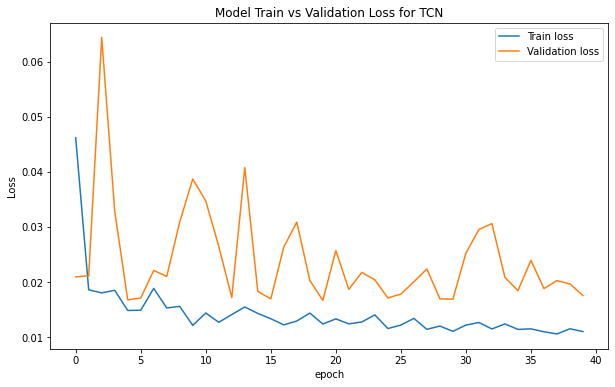

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss for TCN')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

6.63574408755567


Text(0.5, 1.0, 'Performance of Bi-LSTM model')

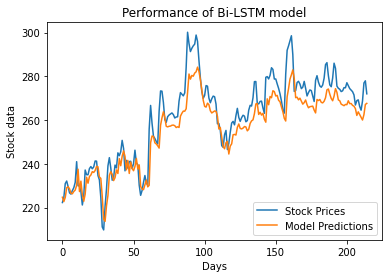

In [ ]:
model = load_model('timeseriesmodel.hdf5')
prediction = model.predict(TEST_X_val)
#prediction = cnt_transformer.inverse_transform(prediction)
range_future = len(prediction)
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(TEST_Y)),label='Test data')
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(prediction)),label='Prediction')
plt.legend(['Stock Prices', 'Model Predictions'], loc='lower right')
print(mean_absolute_error(cnt_transformer.inverse_transform(np.array(TEST_Y)),cnt_transformer.inverse_transform(np.array(prediction))))
plt.xlabel('Days')
plt.ylabel('Stock data')
plt.title('Performance of Bi-LSTM model')

Prediction Type 2

In [ ]:
pip install keras-tcn

     |████████████████████████████████| 706kB 10.6MB/s 


In [ ]:
from tcn import TCN

time_steps, input_dim = 5, 1
tcn_layer = TCN(input_shape=(time_steps, input_dim),nb_filters=128,dropout_rate=0.2)
model=models.Sequential()
model.add(tcn_layer)

model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               542848    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 542,977
Trainable params: 542,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model_checkpoint = ModelCheckpoint('timeseriesmodel_tcn.hdf5',
                                   monitor='val_mae',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')
model.compile(loss='mae',optimizer=optimizer, metrics=['mse','mae'])

In [ ]:
history=model.fit(TRAIN_X_val,TRAIN_Y,epochs=40, batch_size=10,validation_split=0.1,shuffle=True, callbacks=[model_checkpoint])

Epoch 1/40
177/177 [==============================] - 7s 20ms/step - loss: 1.9998 - mse: 103.8322 - mae: 1.9998 - val_loss: 0.0322 - val_mse: 0.0014 - val_mae: 0.0322

Epoch 00001: val_mae improved from inf to 0.03219, saving model to timeseriesmodel_tcn.hdf5
Epoch 2/40
177/177 [==============================] - 3s 15ms/step - loss: 0.0394 - mse: 0.0031 - mae: 0.0394 - val_loss: 0.0959 - val_mse: 0.0100 - val_mae: 0.0959

Epoch 00002: val_mae did not improve from 0.03219
Epoch 3/40
177/177 [==============================] - 3s 14ms/step - loss: 0.0307 - mse: 0.0018 - mae: 0.0307 - val_loss: 0.0693 - val_mse: 0.0054 - val_mae: 0.0693

Epoch 00003: val_mae did not improve from 0.03219
Epoch 4/40
177/177 [==============================] - 3s 15ms/step - loss: 0.0313 - mse: 0.0019 - mae: 0.0313 - val_loss: 0.0566 - val_mse: 0.0037 - val_mae: 0.0566

Epoch 00004: val_mae did not improve from 0.03219
Epoch 5/40
177/177 [==============================] - 3s 14ms/step - loss: 0.0279 - mse: 0.0

3.7111605004110335


Text(0.5, 1.0, 'Performance of TCN model')

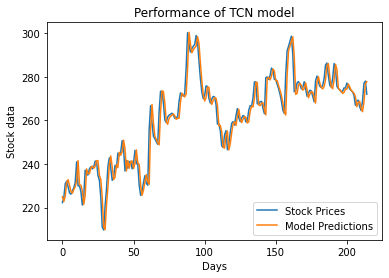

In [ ]:
model_tcn = load_model('timeseriesmodel_tcn.hdf5',custom_objects={'TCN': TCN})
prediction = model_tcn.predict([TEST_X_val])
#prediction = cnt_transformer.inverse_transform(prediction)
range_future = len(prediction)
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(TEST_Y)),label='Test data')
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(prediction)),label='Prediction')
print(mean_absolute_error(cnt_transformer.inverse_transform(np.array(TEST_Y)),cnt_transformer.inverse_transform(np.array(prediction))))
plt.legend(['Stock Prices', 'Model Predictions'], loc='lower right')
plt.xlabel('Days')
plt.ylabel('Stock data')
plt.title('Performance of TCN model')